In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import isnan
import json

In [2]:
def Load_Data(path_dir):
    list_text = os.listdir(path=path_dir)
    text_array = ''
    for text in list_text:
        with open(path_dir + text, 'r') as f:
            text_array+= f.readline() + '\n'
    text_array = text_array.replace('\ufeff', '')
    list_of_files = text_array.split('\n')
    for i in range(len(list_of_files)):
        list_of_files[i] = list_of_files[i].split('\t')
    text_tmp = []
    for i in range(len(list_of_files)):
        if list_of_files[i] != ['']:
            text_tmp.append(list_of_files[i])
    return text_tmp

In [3]:
def ParseData(data):
    list_of_sites, body_array, values = [],[],[];
    for i in range(len(data)):
        body_array.append([])
        for j in range(len(data[i])):
            if j == 0:
                list_of_sites.append(data[i][j])
            elif j == len(data[i])-1:
                values.append([int(data[i][j])])
            else:
                if j != 4:
                    if data[i][j] == 'null':
                        body_array[i].append(0)
                    elif data[i][j] == 'true':
                        body_array[i].append(1)
                    elif data[i][j] == 'false':
                        if j == 2:
                            body_array[i].append(0)
                        else:
                            body_array[i].append(-1)
                    else:
        #                 print(text_array[i][j])
                        body_array[i].append(float(data[i][j]))
    return np.concatenate((np.array(body_array), np.array(values)), axis=1)

In [4]:
data_all = ParseData(Load_Data('Data/'))

In [5]:
import torch
import numpy as np

from torch.optim import Adam

from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch import nn

In [9]:
class PhishingRegressor(nn.Module):
    def __init__(self, name=''):
        super().__init__()
        self.name = name
        self.train = None
        self.test = None
        self.epoch = None
        self.linear1 = nn.Linear(10, 1)
#         self.linear2 = nn.Linear(10, 1)
        
    def forward(self, x):
#         x = torch.tanh(self.linear1(x))
        x = torch.sigmoid(self.linear1(x))
        return x
    
    def Pred(self, data, l):
        loss_new = nn.BCELoss()
        train_loader = DataLoader(dataset=data, batch_size=l)
        acc_new = 0
        for X_batch, y_batch in train_loader:
            y_pred = self(X_batch)
            bce_new = loss_new(y_pred, y_batch)
            acc_new = round(sum([int(y_batch[i] == int(y_pred[i][0]>0.5)) for i in range(y_pred.shape[0])])/l, 3)
        return bce_new, acc_new

    def Data_to_Tensor(self, data, length=[200,20,10]):
        ttv = [[],[],[]]
        np.random.shuffle(data)
        j = 0
        num = 0
        classes = [[],[]]
        for i in range(data.shape[0]):
            classes[int(data[i,-1])].append(data[i])
        for j in range(len(classes)):
            num = 0
            u = 0
            for k in range(len(classes[j])):
                if num != length[u]/2:
                    ttv[u].append(classes[j][k])
                    num += 1
                else:
                    if u < len(length) - 1:
                        u += 1
                        num = 0
                    ttv[u].append(classes[j][k])
                    num += 1
        for i in range(len(ttv)):
            ttv[i] = np.array(ttv[i])
            np.random.shuffle(ttv[i])
        out = []
        for i in range(len(ttv)):
            out.append(TensorDataset(torch.tensor(ttv[i][:,:-1], dtype=torch.float), torch.tensor(ttv[i][:,-1], dtype=torch.float).view(-1,1)))
        return out
    def train_model(self, data, length=[200,20,10]):
        optimizer = Adam(model.parameters(), lr=1e-3)
        epochs, bce_train, bce_val= [], [], []
        loss = nn.BCELoss()
        ltrain, ltest, lval = length
        Data_train, Data_test, Data_val = self.Data_to_Tensor(data)
        train_loader = DataLoader(dataset=Data_train, batch_size=20)
        test_loader = DataLoader(dataset=Data_train, batch_size=ltest)
        train_loader_show = DataLoader(dataset=Data_train, batch_size=ltrain+ltest+lval) 
        epoch = 0
        max_epoch = 4000
        while True:
            epochs.append(epoch)
            for X_batch, y_batch in train_loader:   
                y_pred = self(X_batch)    
                bce = loss(y_pred, y_batch)

                bce.backward()        

                optimizer.step()
                optimizer.zero_grad()       
            
            bce_train.append(bce)
            bce_val.append(self.Pred(Data_val, lval)[0])
            epoch += 1
            if epoch % 100 == 0:
#                 print(bce.detach().numpy().tolist())
                print(f'Epoch = {epoch}, loss = {round(bce.detach().numpy().tolist(), 5)},acc_train = {self.Pred(Data_train,ltrain)[1]}, acc_val = {self.Pred(Data_val,lval)[1]}, acc_test = {self.Pred(Data_test,ltest)[1]}')
            if self.Pred(Data_train,ltrain)[1]>=0.96:
#                 print(self.Pred(Data_test, ltest))
                plt.plot(epochs[:200],bce_train[:200], color='black')
                plt.plot(epochs[:200],bce_val[:200])
                break
            if epoch == max_epoch:
                plt.plot(epochs[:200],bce_train[:200], color='black')
                plt.plot(epochs[:200],bce_val[:200])
                break
        self.train = train_loader_show
        self.test = test_loader
        self.epoch = epoch 
#         return train_loader_show, test_loader
    def Save_model_data(self):
        for data, val in self.train:
            tmp = []
            for i in range(data.shape[0]):
                dict_tr = {}
                dict_tr['input'] = data[i].detach().numpy().tolist()
                dict_tr['output'] = val[i].detach().numpy().tolist()
                tmp.append(dict_tr)
            with open(f'../js_network/Data/train{self.name}.json','w') as f:
                json.dump(tmp, f)
        for data, val in self.test:
            tmp = []
            for i in range(data.shape[0]):
                dict_tr = {}
                dict_tr['input'] = data[i].detach().numpy().tolist()
                dict_tr['output'] = val[i].detach().numpy().tolist()
                tmp.append(dict_tr)
            with open(f'../js_network/Data/test{self.name}.json','w') as f:
                json.dump(tmp, f)

In [10]:
class ConnectModels(nn.Module):
    def __init__(self, name='Connect'):
        super().__init__()
        self.name = name
        self.train = None
        self.test = None
        self.epoch = None
        self.linear1 = nn.Linear(5, 1)
#         self.linear2 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        return x
    
    def Pred(self, data, l):
        loss_new = nn.BCELoss()
        train_loader = DataLoader(dataset=data, batch_size=l)
        acc_new = 0
        for X_batch, y_batch in train_loader:
            y_pred = self(X_batch)
            bce_new = loss_new(y_pred, y_batch)
            acc_new = round(sum([int(y_batch[i] == int(y_pred[i][0]>0.5)) for i in range(y_pred.shape[0])])/l, 3)
        return bce_new, acc_new
    
    def train_model(self, data, length=[200,20,10]):
        optimizer = Adam(model.parameters(), lr=1e-3)
        epochs, bce_train, bce_val= [], [], []
        loss = nn.BCELoss()
        ltrain, ltest, lval = length
        Data_train, Data_test, Data_val = self.Data_to_Tensor(data)
        train_loader = DataLoader(dataset=Data_train, batch_size=20)
#         test_loader = DataLoader(dataset=Data_train, batch_size=ltest)
#         train_loader_show = DataLoader(dataset=Data_train, batch_size=ltrain+ltest+lval) 
        epoch = 0
        max_epoch = 4000
        while True:
            epochs.append(epoch)
            for X_batch, y_batch in train_loader:   
                y_pred = self(X_batch)    
                bce = loss(y_pred, y_batch)

                bce.backward()        

                optimizer.step()
                optimizer.zero_grad()       
            
            bce_train.append(bce)
            bce_val.append(self.Pred(Data_val, lval)[0])
            epoch += 1
            if epoch % 100 == 0:
#                 print(bce.detach().numpy().tolist())
                print(f'Epoch = {epoch}, loss = {round(bce.detach().numpy().tolist(), 5)},\
                      acc_train = {self.Pred(Data_train,ltrain)[1]}, acc_val = {self.Pred(Data_val,lval)[1]},\
                      acc_test = {self.Pred(Data_test,ltest)[1]}')
            if self.Pred(Data_train,ltrain)[1]>=0.97:
#                 print(self.Pred(Data_test, ltest))
                print(f'Epoch = {epoch}, loss = {round(bce.detach().numpy().tolist(), 5)},\
                      acc_train = {self.Pred(Data_train,ltrain)[1]}, acc_val = {self.Pred(Data_val,lval)[1]},\
                      acc_test = {self.Pred(Data_test,ltest)[1]}')
                plt.plot(epochs[:200],bce_train[:200], color='black')
                plt.plot(epochs[:200],bce_val[:200])
                break
            if epoch == max_epoch:
                print(f'Epoch = {epoch}, loss = {round(bce.detach().numpy().tolist(), 5)},\
                      acc_train = {self.Pred(Data_train,ltrain)[1]}, acc_val = {self.Pred(Data_val,lval)[1]},\
                      acc_test = {self.Pred(Data_test,ltest)[1]}')
                plt.plot(epochs[:200],bce_train[:200], color='black')
                plt.plot(epochs[:200],bce_val[:200])
                break
    def Data_to_Tensor(self, data, length=[200,20,10]):
        ttv = [[],[],[]]
        np.random.shuffle(data)
        j = 0
        num = 0
        classes = [[],[]]
        for i in range(data.shape[0]):
            classes[int(data[i,-1])].append(data[i])
        for j in range(len(classes)):
            num = 0
            u = 0
            for k in range(len(classes[j])):
                if num != length[u]/2:
                    ttv[u].append(classes[j][k])
                    num += 1
                else:
                    if u < len(length) - 1:
                        u += 1
                        num = 0
                    ttv[u].append(classes[j][k])
                    num += 1
        for i in range(len(ttv)):
            ttv[i] = np.array(ttv[i])
            np.random.shuffle(ttv[i])
        out = []
        for i in range(len(ttv)):
            out.append(TensorDataset(torch.tensor(ttv[i][:,:-1], dtype=torch.float), torch.tensor(ttv[i][:,-1], dtype=torch.float).view(-1,1)))
        return out

In [11]:
models = [PhishingRegressor(name=str(i+1)) for i in range(5)]

Train model №1:

Epoch = 100, loss = 0.40486,acc_train = 0.905, acc_val = 0.9, acc_test = 1.0
Epoch = 200, loss = 0.28624,acc_train = 0.925, acc_val = 1.0, acc_test = 1.0
Epoch = 300, loss = 0.22742,acc_train = 0.935, acc_val = 1.0, acc_test = 1.0
Epoch = 400, loss = 0.19278,acc_train = 0.94, acc_val = 1.0, acc_test = 1.0
Epoch = 500, loss = 0.17126,acc_train = 0.94, acc_val = 1.0, acc_test = 1.0
Epoch = 600, loss = 0.15742,acc_train = 0.935, acc_val = 1.0, acc_test = 1.0
Epoch = 700, loss = 0.1481,acc_train = 0.935, acc_val = 1.0, acc_test = 1.0
Epoch = 800, loss = 0.14171,acc_train = 0.935, acc_val = 1.0, acc_test = 1.0
Epoch = 900, loss = 0.13736,acc_train = 0.94, acc_val = 1.0, acc_test = 1.0
Epoch = 1000, loss = 0.13445,acc_train = 0.94, acc_val = 1.0, acc_test = 1.0
Epoch = 1100, loss = 0.13254,acc_train = 0.94, acc_val = 1.0, acc_test = 1.0
Epoch = 1200, loss = 0.13132,acc_train = 0.94, acc_val = 1.0, acc_test = 1.0
Epoch = 1300, loss = 0.13059,acc_train = 0.94, acc_val = 1.0, a

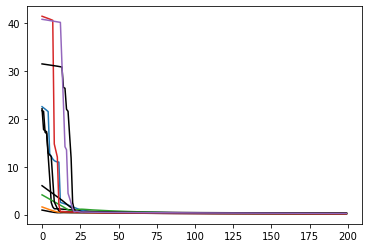

In [12]:
for model in models:
    print(f'Train model №{model.name}:\n')
    model.train_model(data_all)
    print()

In [13]:
def get_color_array(array, f):
    return ['red' if f(array[i]) > 0.5 else 'blue' for i in range(len(array))]

In [14]:
from sklearn.manifold import TSNE

In [15]:
model_to2D = TSNE(learning_rate=1)
transform = model_to2D.fit_transform(data_all[:,:-1])

In [16]:
x = transform[:,0]
y = transform[:,1]

In [17]:
y_val = data_all.T[-1]

In [18]:
y_val_color = get_color_array(y_val, lambda x: x)

In [57]:
%matplotlib
data_for_model = TensorDataset(torch.tensor(data_all[:,:-1], dtype=torch.float), torch.tensor(data_all[:,-1], dtype=torch.float).view(-1,1))
data_load = DataLoader(dataset=data_for_model, batch_size=data_all.shape[0])
f, ax = plt.subplots(5,1)
for a,b in data_load:
    tmp = []
    i = 0
    my_f = lambda x: 0.5
    y_plot = np.array([my_f(x[i]) for i in range(x.shape[0])])
#     print(y_plot)
    for model in models:
        tmp.append(model(a)[:,0].detach().numpy())
        ax[i].scatter(x,model(a)[:,0].detach().numpy(), c=y_val_color)
        ax[i].plot(x,y_plot)
        i+=1
    tmp = np.array(tmp)
    t = b.detach().numpy()
Data_con = np.concatenate((tmp.T, t), axis=1)

Using matplotlib backend: Qt5Agg


In [27]:
Data_con.shape

(230, 6)

In [30]:
model_con = ConnectModels()

Epoch = 100, loss = 0.62975,                      acc_train = 0.875, acc_val = 0.9,                      acc_test = 0.9
Epoch = 200, loss = 0.62975,                      acc_train = 0.875, acc_val = 0.9,                      acc_test = 0.9
Epoch = 300, loss = 0.62975,                      acc_train = 0.875, acc_val = 0.9,                      acc_test = 0.9
Epoch = 400, loss = 0.62975,                      acc_train = 0.875, acc_val = 0.9,                      acc_test = 0.9
Epoch = 500, loss = 0.62975,                      acc_train = 0.875, acc_val = 0.9,                      acc_test = 0.9
Epoch = 600, loss = 0.62975,                      acc_train = 0.875, acc_val = 0.9,                      acc_test = 0.9
Epoch = 700, loss = 0.62975,                      acc_train = 0.875, acc_val = 0.9,                      acc_test = 0.9
Epoch = 800, loss = 0.62975,                      acc_train = 0.875, acc_val = 0.9,                      acc_test = 0.9
Epoch = 900, loss = 0.62975,            

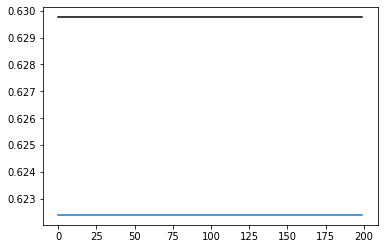

In [31]:
model_con.train_model(Data_con)

In [32]:
t[:5,:].shape

(5, 1)

In [33]:
tmp.shape

(5, 230)

In [594]:
max_coef = []
max_acc = 0
for i in range(tmp.T.shape[0]-5):
    if np.linalg.det(tmp.T[i:i+5,:])!= 0:
        k = np.linalg.inv(tmp.T[i:i+5,:]).dot(t[:5,:])
        tr = tmp.T.dot(k)
        acc = sum([int(t[j] == int(tr[j]>0.5)) for j in range(tr.shape[0])])/tr.shape[0]
#         print(acc)
        if max_acc < acc:
            max_acc = acc
            max_coef = k
max_coef, max_acc

(array([[ 0.18202019],
        [-1.5083923 ],
        [-1.5250931 ],
        [-0.7515869 ],
        [ 4.598419  ]], dtype=float32),
 0.9608695652173913)

In [553]:
h = np.array([[1,2,3],[4,5,6]])
sum(h)

array([5, 7, 9])

In [123]:
res_train_color = get_color_array(X_train, model)

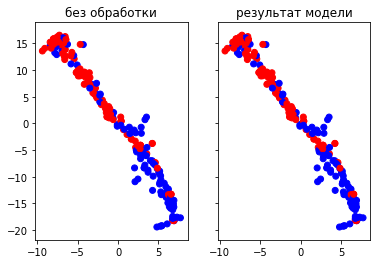

In [21]:
f_train, ax1 = plt.subplots(1,2, sharey=True)
ax1[0].scatter(x, y, c=val_train_color)
ax1[0].set_title('без обработки')
ax1[1].scatter(x, y, c=res_train_color)
ax1[1].set_title('результат модели')
plt.show()

In [22]:
transform_test = model_to2D.fit_transform(data_test)
x_2 = transform_test[:, 0]
y_2 = transform_test[:, 1]

In [24]:
res_color_test = get_color_array(X_test, model)

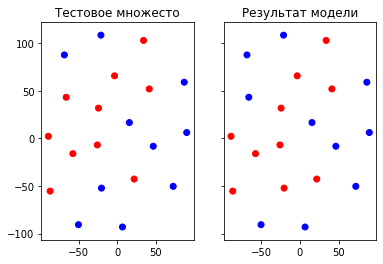

In [25]:
f_test, ax2 = plt.subplots(1,2, sharey=True)
ax2[0].scatter(x_2, y_2, c=val_test_color)
ax2[0].set_title('Тестовое множесто')
ax2[1].scatter(x_2, y_2, c=res_color_test)
ax2[1].set_title('Результат модели')
plt.show()

In [26]:
acc = sum([int(val_test[i] == int(model(X_test[i])>0.5)) for i in range(X_test.shape[0])])/X_test.shape[0]

In [27]:
acc

0.9

In [28]:
def F_b (b=1):
    return (1+b**2)*(precision*recall)/(b**2*precision+recall)

In [29]:
TP = 0
FP = 0
FN = 0
for i in range(len(val_test)):
    if val_test[i] == int(model(X_test[i])>0.5):
        if int(model(X_test[i])>0.5) == 1:
            TP += 1
    else:
        if int(model(X_test[i])>0.5) == 0:
            FN += 1
        else:
            FP += 1
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F_b()

0.9

In [53]:
a = np.array([[1,2,4]])
b = np.array([[5,6,7]])

In [56]:
np.concatenate((a,b), axis=0)

array([[1, 2, 4],
       [5, 6, 7]])

In [12]:
X_test = torch.tensor(data_test, dtype=torch.float)

In [11]:
X_train = torch.tensor(data_train, dtype=torch.float)
y_train = torch.tensor(val_train, dtype=torch.float).view(-1,1)

In [13]:
data = TensorDataset(X_train, y_train)

In [50]:

def train_model():
    optimizer = Adam(model.parameters(), lr=1e-3)

    loss = nn.BCELoss()
    train_loader = DataLoader(dataset=data, batch_size=20)
    epoch = 0
    while True:
        for X_batch, y_batch in train_loader:   
            y_pred = model(X_batch)    
            bce = loss(y_pred, y_batch)

            bce.backward()        

            optimizer.step()
            optimizer.zero_grad()       
           
        epoch += 1
        if epoch % 100 == 0:
            acc_val = round(sum([int(val_val[i] == int(model(X_val[i])>0.5)) for i in range(X_val.shape[0])])/val_val.shape[0], 2)
            acc_test = round(sum([int(val_test[i] == int(model(X_test[i])>0.5)) for i in range(X_test.shape[0])])/val_test.shape[0], 2)
            print(f'Epoch = {epoch}, loss = {bce}, acc_val = {acc_val}, acc_test = {acc_test}')
        if bce < 0.0001:
            break
        if epoch == 10000:
            break

In [34]:
data_for_model = TensorDataset(torch.tensor(data_all[:,:-1], dtype=torch.float), torch.tensor(data_all[:,-1], dtype=torch.float).view(-1,1))
data_load = DataLoader(dataset=data_for_model, batch_size=data_all.shape[0])
for a,b in data_load:
    tmp = []
    for model in models:
        tmp.append(model(a)[:,0].detach().numpy())
    tmp = np.array(tmp).T

In [35]:
tmp = torch.Tensor(tmp)

In [36]:
tmp.shape

torch.Size([230, 5])

In [38]:
y_pred_last = model_con(tmp)[:,0].detach().numpy()

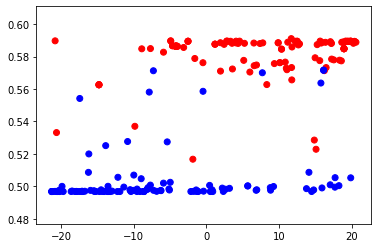

In [39]:
plt.scatter(x,y_pred_last,c=y_val_color)